# Compute Sun and Moon Altitude for a Location with `astropy` - Pt. 1

It is rather simple to create your own astronomy calendar with [Astropy Project](https://www.astropy.org/). In this simple example, we will create a location on Earth (an `EarthLocation` in `astropy` parlance). 

Note that the location is a geodetic lat, lon defined on a WGS84 Ellipsoid. This is usually what you mean when you talk about latitudes and longitudes. 

We will also assign a Time Zone to make sure the output timings are in local time.

In [77]:
from astropy.coordinates import EarthLocation
from astropy import units as u

import pytz

# Init location - default Ellipsoid is WGS84
istanbul = EarthLocation(lat=41.015137, lon=28.979530, height=0 * u.m)
ist_timezone = pytz.timezone("Turkey")

The next step is to set up the simulation duration and timestep. Default example is 10 minutes timestep and one day duration.

In [78]:
from astropy.time import Time, TimeDelta

# Time analysis config (stepsize, duration, init time)
init_time = Time("2020-04-12T00:00:00", scale="utc")
dt = TimeDelta(10 * 60.0, format="sec")  # stepsize
duration = TimeDelta(1.0, format="jd")  # duration

Now that the analysis setup is complete, we have to generate the time instant for each simulation step and generate the accompanying Alt-Az frame. The frame is centered on the initial `EarthLocation` object and will be used to output the target location (in our example, Sun and Moon) in terms of [horizontal coordinates](https://en.wikipedia.org/wiki/Horizontal_coordinate_system) i.e., Altitude, Azimuth and Range.

For the uninitiated, Azimuth 0 degrees denotes the North and Azimuth 90 degrees denotes th East directions. Altitude (or Elevation) 0 corresponds to horizon and increases as you go up, with Altitude 90 degrees corresponding to _up_ direction, or Zenith.

In [79]:
import numpy as np
from astropy.coordinates import AltAz

# Generate observation time list
dt_list = dt * np.arange(0, duration.sec / dt.sec, 1)
obs_times: Time = init_time + dt_list

# Init the frames for each time
alt_az_frames: AltAz = AltAz(location=istanbul, obstime=obs_times)

With this setup, we can track the Alt-Az coordinates of any object over the skies of Istanbul. In our example, we will use Sun and Moon. We will initialise their position vectors for each instant of `obs_times`, then we will immediately convert them to the local Az-Alt coordinates, as seen from the `EarthLocation` defined at the beginning.

In [80]:
from astropy.coordinates import get_sun, get_moon

# Generate the Sun coords in Alt Az
sun_alt_az_list = get_sun(obs_times).transform_to(alt_az_frames)
moon_alt_az_list = get_moon(obs_times).transform_to(alt_az_frames)

print(f"Sun at {obs_times[0]}:")
print(sun_alt_az_list[0])
print(f"Moon at {obs_times[-1]}:")
print(moon_alt_az_list[-1])

Sun at 2020-04-12T00:00:00.000:
<SkyCoord (AltAz: obstime=2020-04-12T00:00:00.000, location=(4216053.68177813, 2335028.02944204, 4163691.74082622) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (34.84018753, -33.6106746, 1.49962292e+11)>
Moon at 2020-04-12T23:50:00.000:
<SkyCoord (AltAz: obstime=2020-04-12T23:50:00.000, location=(4216053.68177813, 2335028.02944204, 4163691.74082622) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (140.73617081, 14.00901164, 3.76907565e+08)>


That really is it. As an example, we output Sun and Moon at two time instants and we see that we get _a lot of_ information in a `SkyCoord` object (though many of them not initialised). Not only we get Alt and Az angles, we also get the distance at these instances.

As these things are wont, we have to prepare a nice plot. Unfortunately, this requires a lot of tedious preparation. One thing we do at the beginning is to convert the Astropy `Time` object to Python `datetime` object, so that it is comprehensible to Matplotlib.

We also plot a 5 degree elevation angle limit to show where the Sun or Moon would realistically be seen. Also a good excuse to show how a horizontal line can be easily added.

One last trick is to show the date and time nicely on the x axis. We can either use the `autofmt_xdate()` method on the "current figure" or we can manually add a 90 degree rotation on the x axis values.

Finally, you can find the complete code [here in GitHub](https://github.com/egemenimre/satstuff/blob/master/examples/astropy/sun_moon_alt.py).

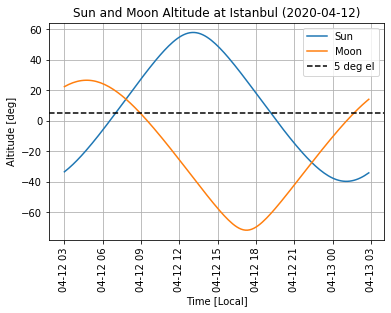

In [81]:
%matplotlib inline

# Convert astorpy Time list to datetime
time_list = obs_times.to_datetime(timezone=ist_timezone)
plt.plot(time_list, sun_alt_az_list.alt.deg, time_list, moon_alt_az_list.alt.deg)

plt.grid()  # Turn grid on

# Plot a min elevation angle limit
min_elev = 5  # deg
plt.axhline(min_elev, color="k", ls="dashed")

# format the time labels on x-axis
# plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)

plt.title(f"Sun and Moon Altitude at Istanbul ({init_time.to_datetime(timezone=ist_timezone).date()})")
plt.xlabel("Time [Local]")
plt.ylabel("Altitude [deg]")
plt.legend(["Sun", "Moon", f"{min_elev} deg el"])

plt.show()